In [15]:
import numpy as np
import logging
import sys
from matplotlib import pyplot as plt
import torch
from math import atan2,degrees

%matplotlib inline
sys.path.append("../")

from generate_gaussian_data import true_logp
from aef.models.autoencoding_flow import TwoStepAutoencodingFlow
from aef.trainer import AutoencodingFlowTrainer, NumpyDataset
from aef.losses import nll, mse

logging.basicConfig(
    format="%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.INFO,
)



## Load data

In [7]:
data_dims = [8,16,32,64,128]
true_latent_dim = 8
latent_dims = [np.load("../data/results/latent_dims_gaussian_{}.npy".format(x)) for x in data_dims]
mse_reco_tests = [np.load("../data/results/mse_reco_test_gaussian_{}.npy".format(x)) for x in data_dims]
mse_log_likelihood_tests = [np.load("../data/results/mse_log_likelihood_test_gaussian_{}.npy".format(x)) for x in data_dims]
nll_tests = [np.load("../data/results/nll_test_gaussian_{}.npy".format(x)) for x in data_dims]
nll_gens = [np.load("../data/results/nll_gen_gaussian_{}.npy".format(x)) for x in data_dims]

## Plot

In [8]:
#Label line with line2D label data
def labelLine(line,y,label=None,align=True,**kwargs):

    ax = line.axes
    xdata = line.get_xdata()
    ydata = line.get_ydata()

    assert ydata[0] < y <  ydata[-1]

    #Find corresponding x co-ordinate and angle of the line
    ip = 1
    for i in range(len(ydata)):
        if y < ydata[i]:
            ip = i
            break

    x = xdata[ip-1] + (xdata[ip]-xdata[ip-1])*(y-ydata[ip-1])/(ydata[ip]-ydata[ip-1])
    if not label:
        label = line.get_label()

    if align:
        #Compute the slope
        dx = xdata[ip] - xdata[ip-1]
        dy = ydata[ip] - ydata[ip-1]
        ang = degrees(atan2(dy,dx))

        #Transform to screen co-ordinates
        pt = np.array([x,y]).reshape((1,2))
        trans_angle = ax.transData.transform_angles(np.array((ang,)),pt)[0]

    else:
        trans_angle = 0

    # Set a bunch of keyword arguments
    if 'color' not in kwargs:
        kwargs['color'] = line.get_color()
    if ('horizontalalignment' not in kwargs) and ('ha' not in kwargs):
        kwargs['ha'] = 'center'
    if ('verticalalignment' not in kwargs) and ('va' not in kwargs):
        kwargs['va'] = 'center'
    if 'backgroundcolor' not in kwargs:
        kwargs['backgroundcolor'] = ax.get_facecolor()
    if 'clip_on' not in kwargs:
        kwargs['clip_on'] = True
    if 'zorder' not in kwargs:
        kwargs['zorder'] = -10.

    ax.text(x,y,label,rotation=trans_angle,**kwargs)

def labelLines(lines,align=True,xvals=None,**kwargs):

    ax = lines[0].axes
    labLines = []
    labels = []

    #Take only the lines which have labels other than the default ones
    for line in lines:
        label = line.get_label()
        if "_line" not in label:
            labLines.append(line)
            labels.append(label)

    if xvals is None:
        xmin,xmax = ax.get_xlim()
        xvals = np.linspace(xmin,xmax,len(labLines)+2)[1:-1]

    for line,x,label in zip(labLines,xvals,labels):
        labelLine(line,x,label,align,**kwargs)

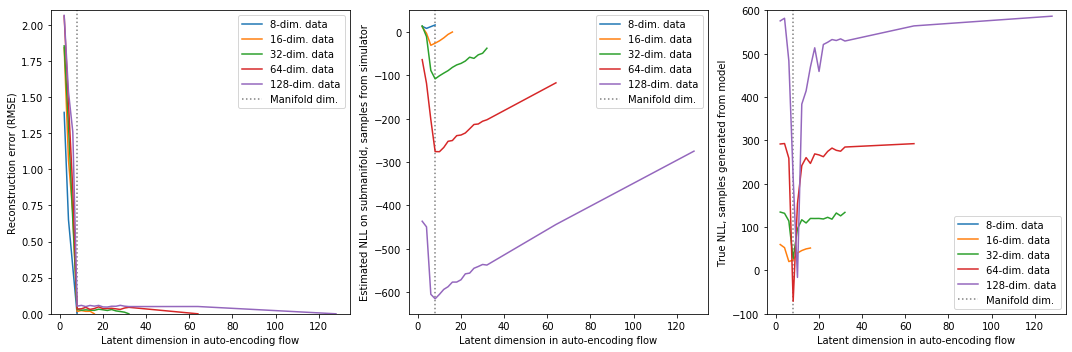

In [14]:
plt.figure(figsize=(10, 10))

ax = plt.subplot(2,2,1)
for data_dim, x, y in zip(data_dims, latent_dims, mse_reco_tests):
    plt.plot(x, y**0.5, label="{}-dim. data".format(data_dim))
plt.plot([8, 8], [-1000., 1000.], ls=":", c="0.5", zorder=-11., label="Manifold dim.")
plt.legend()
#labelLine(line=plt.gca().get_lines()[-1], label="True submanifold dimension", y=1.5)
#plt.yscale("log")
plt.ylim(0.,2.1)
plt.title("Submanifold", fontsize=12)
plt.xlabel("Latent dimension in auto-encoding flow")
plt.ylabel("Reconstruction error (RMSE)")

ax = plt.subplot(2,2,3)
for data_dim, x, y in zip(data_dims, latent_dims, mse_log_likelihood_tests):
    plt.plot(x, y, label="{}-dim. data".format(data_dim))
plt.plot([8, 8], [-1000., 1000.], ls=":", c="0.5", zorder=-11., label="Manifold dim.")
plt.legend()
#labelLine(line=plt.gca().get_lines()[-1], label="True submanifold dimension", y=-300)
plt.ylim(-650,50)
plt.title("Inference (1)", fontsize=12)
plt.xlabel("Latent dimension in auto-encoding flow")
plt.ylabel("Error in submanifold likelihood estimation (RMSE on log p)")

ax = plt.subplot(2,2,3)
for data_dim, x, y in zip(data_dims, latent_dims, nll_tests):
    plt.plot(x, y, label="{}-dim. data".format(data_dim))
plt.plot([8, 8], [-1000., 1000.], ls=":", c="0.5", zorder=-11., label="Manifold dim.")
plt.legend()
#labelLine(line=plt.gca().get_lines()[-1], label="True submanifold dimension", y=-300)
plt.ylim(-650,50)
plt.title("Inference (2)", fontsize=12)
plt.xlabel("Latent dimension in auto-encoding flow")
plt.ylabel("Estimated submanifold NLL, on samples from simulator")

ax = plt.subplot(2,2,4)
for data_dim, x, y in zip(data_dims, latent_dims, nll_gens):
    plt.plot(x, y, label="{}-dim. data".format(data_dim))
plt.plot([8, 8], [-1000., 1000.], ls=":", c="0.5", zorder=-11., label="Manifold dim.")
plt.legend()
# labelLine(line=plt.gca().get_lines()[-1], label="True submanifold dimension", y=400)
plt.ylim(-100,600)
plt.title("Generative mode", fontsize=12)
plt.xlabel("Latent dimension in auto-encoding flow")
plt.ylabel("True NLL, on samples generated from model")

plt.tight_layout()
plt.savefig("../figures/scanning_latent_dim_gaussian.pdf")